In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
# All import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Read Data

In [2]:
data = pd.read_csv('~/nu_ds_challenge/ml_assignment_data_train.csv')
print('Shape of the dataset is:', data.shape)
data.head()

Shape of the dataset is: (258325, 11)


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26 18:31:19,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27 22:49:51,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16 17:54:07,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16 00:47:10,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07 17:09:09,165,GB,81349.76,succeeded


# Data Cleaning

- Ensure all columns are the correct dtype
    - 'lauched' and 'deadline' column to datetime dtype


In [3]:
data.dtypes

name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
backers            int64
country           object
usd_goal_real    float64
new_state         object
dtype: object

In [4]:
data_v1 = data.assign(
    deadline = pd.to_datetime(pd.to_datetime(data.deadline).dt.date),
    launched = pd.to_datetime(pd.to_datetime(data.launched).dt.date)
)
data_v1.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,succeeded


- Check for missing values
        - 3 missing values in the name column. Delete these rows as they account for less than 0.1% of the dataset

In [5]:
nulls = pd.DataFrame(data_v1.isnull().sum(), columns=['count_nulls']).sort_values(by=['count_nulls'], ascending=False)
nulls[nulls.count_nulls > 0]

,count_nulls
name,3


In [6]:
# removing rows with missing names
data_v2 = data_v1[data_v1.name.isnull() == False]

- Map output variables [failed, succeeded, surged] to [0,1,2]

In [7]:
data_v2['new_state'] = data_v2.new_state.map({'failed':0,'succeeded':1, 'surged':2 })

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
data_v2.new_state.unique()
data_v2.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1


# Initial Feature Engineering

- For date columns
    - time_period = deadline - launched
    - Month of year launched
    - Year of launch
- For name column
    - len of title
    - number of words in the title
    - (Note: Maybe for future model improvement) Look at the successful or surged titles, remove stop words and make features of the words 

In [9]:
data_v2['name_length'] = data_v2.name.apply(lambda x: len(x))
data_v2['name_num_words'] = data_v2.name.apply(lambda x: len(x.split()))
data_v2.head()

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7


In [10]:
data_v2 = data_v2.assign(
    launch_month = data_v2.launched.dt.month,
    duration_launched_month = ((data_v2.deadline - data_v2.launched)/np.timedelta64(1, 'M')),
    launch_year = data_v2.launched.dt.year
)
data_v2.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,2012
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,2017
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8,8,1.018501,2016
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5,6,1.544180,2013
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7,11,0.985647,2013


# EDA

There are a total of 10 features in the dataset. I want to do some quick introductory analysis on each of them so I have a good understand of the distrubution of the dataset. 

First Up: new_state

In [12]:
print('These are the classification variables of the dataset', data_v2.new_state.unique())
class_var = pd.DataFrame(data_v2.new_state.value_counts())
class_var = class_var.assign(percent_class = round(class_var.new_state/258322, 2)*100)
print(class_var)

These are the classification variables of the dataset [0 1 2]
   new_state  percent_class
0     158171           61.0
1      66635           26.0
2      33516           13.0


61%, 26% and 13% of the dataset consist of books that failed, succeeded and surged.


Next: goal and usd_goal_real


I will assume the 'goal' column is also in USD

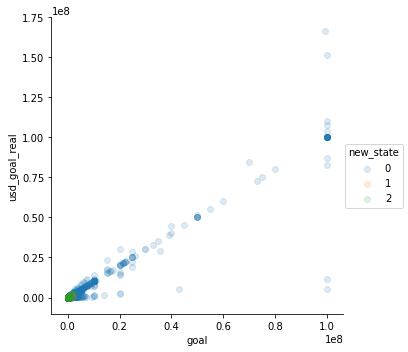

In [13]:
sns.lmplot( x="goal", y="usd_goal_real", 
           data=data_v2, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

Based on the plot, it is evident that the extremely high goals are unlikely to be successful. I hypothesize that this could be due to unrealistic expectations or over hypness of the book. Let's take out some outliers and see the same scatter plot.

Shape of the data removing 99 percentile from the goals columns is: (255738, 16)


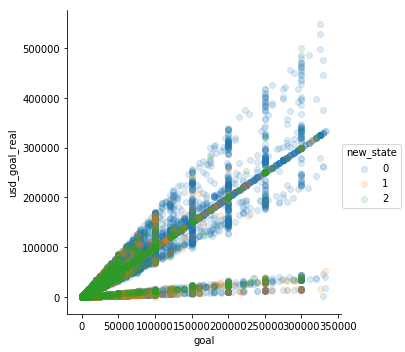

In [41]:
quantile = .99
print('Shape of the data removing 99 percentile from the goals columns is:',
      data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)].shape)

sns.lmplot( x="goal", y="usd_goal_real", 
           data=data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)], 
           fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

In the plot above, the lower the goal the higher the probability of success.

Next: Currency

There are 14 different currencies in this dataset.
USD    203876
GBP     22949
EUR     11120
CAD      9613
AUD      5083
Name: currency, dtype: int64


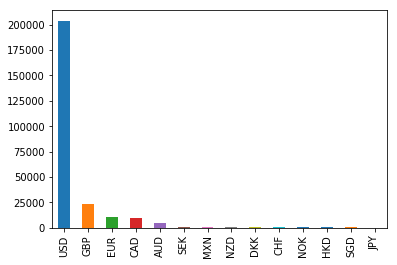

In [15]:
print('There are', data_v2.currency.nunique(), 'different currencies in this dataset.')
print(data_v2.currency.value_counts().head())
data_v2.currency.value_counts().plot(kind="bar")

In the plot above, it is evident that over 75% of the currency in the dataset is USD.


Next: Country

There are 23 different countries in the dataset.
US    203749
GB     22930
CA      9609
AU      5082
DE      2640
Name: country, dtype: int64


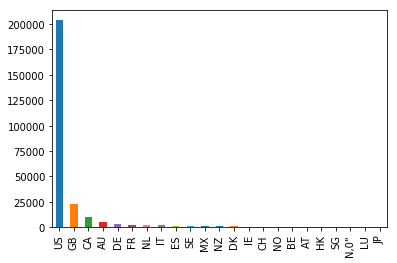

In [16]:
data_v2.country.unique()
print('There are', data_v2.country.nunique(), 'different countries in the dataset.')
print(data_v2.country.value_counts().head())
data_v2.country.value_counts().plot(kind="bar")

The country distribution is similar to the currency distribution

Next: Names of the Books

In [17]:
data_v2.name.nunique()/data_v2.shape[0]
name_counts = pd.DataFrame(data_v2.name.value_counts())
name_counts[name_counts['name'] > 1].shape

print(name_counts[name_counts['name'] > 1].shape[0], 'books in the dataset have duplicate names.',
     'This is', name_counts['name'][name_counts['name'] > 1].sum(), 
      'total rows in the dataset with duplicate book names (', 
      round((1-(data_v2.name.nunique()/data_v2.shape[0])),2)*100,
     '% of the dataset)')

1072 books in the dataset have duplicate names. This is 2432 total rows in the dataset with duplicate book names ( 1.0 % of the dataset)


Next: main_category

There are 15 different main categories.
Here are the t
              main_category
Film & Video          44878
Music                 36541
Publishing            28058
Technology            20676
Games                 20630


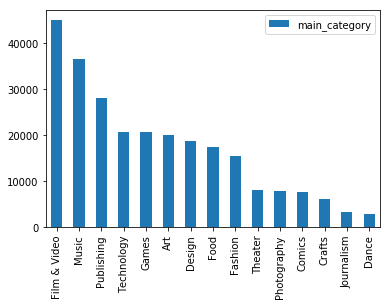

In [18]:
data_v2.main_category.unique()
print('There are', data_v2.main_category.nunique(), 'different main categories.')
main_category_counts = pd.DataFrame(data_v2.main_category.value_counts())
print('Here are the t')
print(main_category_counts.head())
main_category_counts.plot.bar()

For unique book names, I do not think it would add much value to one-hot-encode the names as a feature to the model. There are also very few duplicate names. Thus, other features may have to be extracted from the name which will be done in the feature engineering section of the code!


Next: category

There are a total of 159 categories
Here are the top 5 categories:
                category
Product Design     13723
Documentary        11578
Music              10071
Shorts              9035
Food                8303
Following is a bar plot of the top 20 categories:


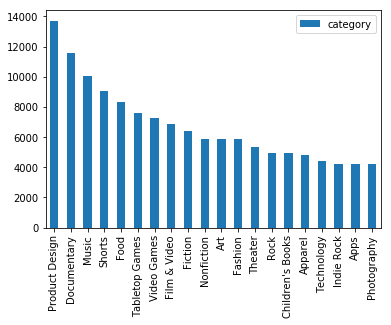

In [19]:
data_v2.category.unique()
print('There are a total of', data_v2.category.nunique(),'categories')
print('Here are the top 5 categories:')
category_counts = pd.DataFrame(data_v2.category.value_counts())
print(category_counts.head())
print('Following is a bar plot of the top 20 categories:')
category_counts.head(20).plot.bar()

Next: launch_year

In [23]:
data_v2.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'backers', 'country', 'usd_goal_real', 'new_state',
       'name_length', 'name_num_words', 'launch_month',
       'duration_launched_month', 'launch_year'],
      dtype='object')

These are the following counts by year:
   year  count
8  2009    924
7  2010   7619
6  2011  19012
5  2012  30350
4  2013  31955
1  2014  46484
0  2015  50853
2  2016  38028
3  2017  33097


<BarContainer object of 9 artists>

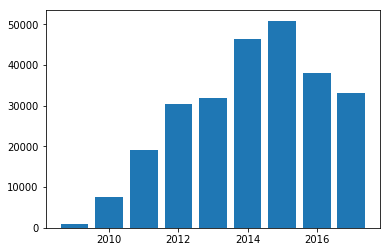

In [39]:
year_counts = (data_v2.launch_year.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'year', 'launch_year': 'count'})
                )
print('These are the following counts by year:')
print(year_counts)
plt.bar(year_counts['year'], year_counts['count'])

There is an increasing trend in the number of kickstarters year over year till 2015 (peak year). After 2015, there is a drop in the number of kickstarters by more tha 10000.

In [51]:
data_v2.head(1)

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,duration_launched_month,launch_year,char_per_name_word
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.0,0,34,7,10,1.182776,2012,4.857143


These are the following counts by month:
    month  count
10      1  18878
9       2  20502
1       3  23466
5       4  22317
3       5  22754
4       6  22578
0       7  24975
6       8  22249
8       9  21333
2      10  22779
7      11  22118
11     12  14373


<BarContainer object of 12 artists>

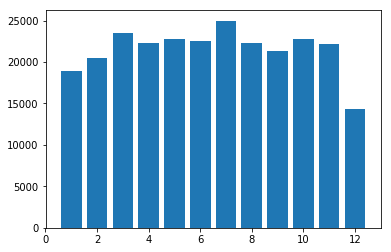

In [52]:
month_counts = (data_v2.launch_month.value_counts()
                    .reset_index()
                    .sort_values(by=['index'], ascending=True)
                    .rename(columns={'index': 'month', 'launch_month': 'count'})
                )
print('These are the following counts by month:')
print(month_counts)
plt.bar(month_counts['month'], month_counts['count'])

December (14373) has the least number of kickstarter projects launched whereas July (24,975) has the most.


Next: name_length & name_num_words

Histogram of the length of kickstarter names:


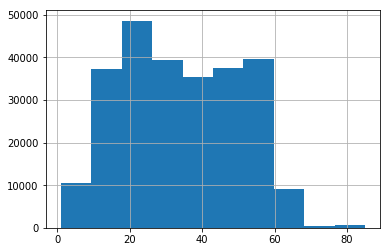

In [56]:
print('Histogram of the length of kickstarter names:')
data_v2.name_length.hist(bins=10)

Histogram of the number of words of kickstarter names:


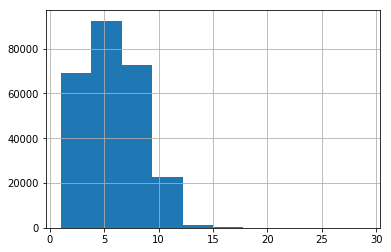

In [55]:
print('Histogram of the number of words of kickstarter names:')
data_v2.name_num_words.hist(bins=10)

Next: backers

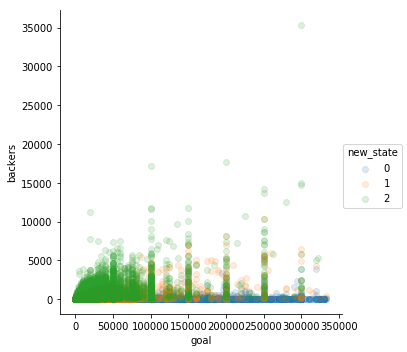

In [43]:
backers_plot_data = data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)]
sns.lmplot( x="goal", y="backers", 
           data=backers_plot_data, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

From the plot above, the higher the goal the more likely the kickstarter is to fail. However, if the kickstarter project has a lot of backers, then it is evident to have a higher probability of success.

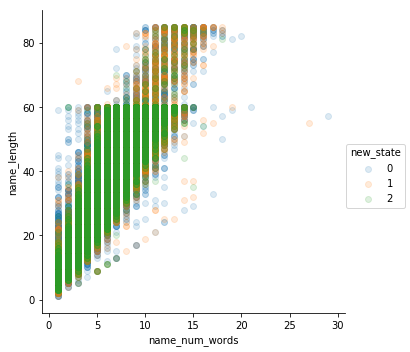

In [49]:
backers_plot_data = data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)]
sns.lmplot( x="name_num_words", y="name_length", 
           data=backers_plot_data, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

# Benchmarking
I will be using K-nearest neighbors as a benchmark model. K-NN does not usually provide competitive accuracy in comparision to other more complex supervised machine learning algorithms.

#### Preprocessing Data for K-NN
Specfic features from the dataset will be picked and scaled using MinMaxScaler for the model. The model will be divided into a train and test set. The best K will be picked using GridSearchcv on the train set. The model will then be implemented on the test set to get the benchmarking metrics.

#### Model Performance
Accuracy and log_loss will be used to evaluate model performance.

## K-NN Preprocessing
#### Picking Features
I will use the following features for the K-NN model:


'main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year', 'duration_launched_month'

In [62]:
X = data_v2[['main_category', 'country', 'backers', 'usd_goal_real', 'launch_month', 'launch_year',
             'duration_launched_month']]
y = data_v2[['new_state']]
X.head(2)

,main_category,country,backers,usd_goal_real,launch_month,launch_year,duration_launched_month
0,Publishing,US,0,8000.00,10,2012,1.182776
1,Journalism,GB,2,2587.82,2,2017,1.971293


#### Preprocessing Features
- one hot encode object features

In [64]:
X_dummies = pd.get_dummies(X)
X_dummies.head(2)

,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,8000.00,10,2012,1.182776,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,2587.82,2,2017,1.971293,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- MinMaxScaler on entire set

In [72]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dummies), columns=X_dummies.columns)
X_scaled.head(2)

,backers,usd_goal_real,launch_month,launch_year,duration_launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0.000000,0.000048,0.818182,0.375,0.384615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000027,0.000016,0.090909,1.000,0.648352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- change the shape of y
- Split data into training and testing set

In [90]:
y = np.array(y).ravel()
y.shape

(258322,)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
print('Shape of training set is:', X_train.shape)
print('Shape of testing set is:', X_test.shape)

Shape of training set is: (206657, 43)
Shape of testing set is: (51665, 43)


#### Train K-NN model
- Using gridsearchcv to try out different ranges of k on the training set

In [97]:
knn_model = KNeighborsClassifier()
knn_model_params = {'n_neighbors': np.arange(1,5)}

In [98]:
# %%time
# knn_model_cv = GridSearchCV(knn_model,param_grid=knn_model_params,cv=3, verbose=3)
# knn_model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.6553726446592921, total= 2.6min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6568678686525564, total= 2.4min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.6546853451404515, total= 2.7min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6775832534912755, total= 2.8min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6793542955027146, total= 2.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.6777382594178704, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6709636210550765, total= 2.7min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6720523763899776, total= 2.4min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.6711040139362706, total= 2.8min
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 84.9min finished


CPU times: user 1h 23min 33s, sys: 34.9 s, total: 1h 24min 8s
Wall time: 1h 25min 48s


In [99]:
# print('The best score is:', knn_model_cv.best_score_)
# print('The best k value is:', knn_model_cv.best_params_)

The best score is: 0.6782252718272306
The best k value is: {'n_neighbors': 2}


#### Testing K-NN model
- apply k-nn model on test set


In [101]:
%%time
knn_test = KNeighborsClassifier()
knn_test.fit(X_train,y_train)
knn_predictions = knn_test.predict(X_test)

CPU times: user 3min 54s, sys: 1.61 s, total: 3min 56s
Wall time: 4min 1s


In [125]:
%%time
knn_prob_predictions = knn_test.predict_proba(X_test)

CPU times: user 2min 48s, sys: 717 ms, total: 2min 49s
Wall time: 2min 50s


- Evaluate the model performance

In [127]:
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions))
print("Log_loss:",metrics.log_loss(y_test, knn_prob_predictions))

Accuracy: 0.6866156972805575
Log_loss: 3.5592535094921773


Will use the accuracy of 68.7% and log loss of 3.56 as a benchmark for the model. These benchmark metrics are credible because if every row in the test dataset was predicted as failed, the accuracy would be approximately 61% (61% of the dataset is labeled as failed).


Let's apply a more sophisticated model to see if we can improve these evalution metrics.

# Model Implementation

## Boosting via LightGBM

## Neural Networks via PyTorch (for fun)

Improvements
- Benchmarking took too long using K-NN. Next time benchmarking can be done by mapping a predictions to a simple function using the distributions of the dataset. 
    - Eg: Derive a random number for each row in the dataset. If the random number is between [0,60], [61,87] and [87,100], predict classes failed, succeeded and surged.
- Due to time constraint, I trained the k-nn model based on accuracy instead of log_loss (Cross Entropy)
- Removing outliers in the model?